In [1]:
import json
import pandas as pd
from tldextract import extract
from typing import List
import numpy as np
import matplotlib.pyplot as plt

In [2]:
COOKIE_DURATION_COLUMN = 'duration_s'

In [3]:
def domain_from_uri(uri: str) -> str:
    return '.'.join(extract(uri)[-2:])

In [4]:
def calc_cookie_duration(row: pd.Series) -> List[dict]:
    timestamp, cookies = row[0], row[1]
    for cookie in cookies:
        cookie[COOKIE_DURATION_COLUMN] = cookie.get('expiry', timestamp) - timestamp
    return cookies

In [5]:
# ['source_ip', 'dns_module', 'rdap_module', 'browser_module.uri',
#        'browser_module.page_source', 'browser_module.page_title',
#        'browser_module.resources_ordlist', 'browser_module.redirection_chain',
#        'browser_module.exception', 'browser_module.exception_str',
#        'browser_module.start_ts', 'browser_module.end_ts',
#        'browser_module.cookies.request_timestamp',
#        'browser_module.cookies.cookies', 'browser_module.banner_detected',
#        'browser_module.screenshot_file', 'domain']
def load_output(output_file, keep_cols=None) -> pd.DataFrame:
    if keep_cols is None:
        keep_cols = [
            'browser_module.exception',
            'browser_module.uri',
            'browser_module.cookies.request_timestamp',
            'browser_module.cookies.cookies',
            'browser_module.screenshot_file',
            'browser_module.banner_detected',
            'domain'
        ]

    with open(output_file, 'r') as f:
        lines = f.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']

    df_ = pd.json_normalize(df_inter['json_element'].apply(json.loads))

    # TODO extract (base) domain
    df_['domain'] = df_['browser_module.uri'].apply(domain_from_uri)
    df_['browser_module.cookies.cookies'] = df_[['browser_module.cookies.request_timestamp','browser_module.cookies.cookies']].apply(calc_cookie_duration, axis=1)
    return df_[keep_cols]

In [6]:
df = load_output("../resources/dutch_run_1/results.jsonl")
df.columns
df

,browser_module.exception,browser_module.uri,browser_module.cookies.request_timestamp,browser_module.cookies.cookies,browser_module.screenshot_file,browser_module.banner_detected,domain
0,None,https://www.hostnet.nl,1.646761e+09,"[{'domain': '.hostnet.nl', 'httpOnly': False, ...",C:\Users\ptema\Documents\uni\y4\hacking-lab\re...,False,hostnet.nl
1,None,http://www.hostnet.nl,1.646761e+09,"[{'domain': '.hostnet.nl', 'httpOnly': True, '...",C:\Users\ptema\Documents\uni\y4\hacking-lab\re...,False,hostnet.nl
2,None,https://hostnet.nl,1.646761e+09,"[{'domain': '.hostnet.nl', 'httpOnly': True, '...",C:\Users\ptema\Documents\uni\y4\hacking-lab\re...,False,hostnet.nl
3,None,http://maastrichtuniversity.nl,1.646761e+09,"[{'domain': 'www.maastrichtuniversity.nl', 'ex...",C:\Users\ptema\Documents\uni\y4\hacking-lab\re...,True,maastrichtuniversity.nl
4,None,http://hostnet.nl,1.646761e+09,"[{'domain': '.hostnet.nl', 'httpOnly': True, '...",C:\Users\ptema\Documents\uni\y4\hacking-lab\re...,False,hostnet.nl
...,...,...,...,...,...,...,...
182,None,http://utwente.nl,1.646762e+09,"[{'domain': 'www.utwente.nl', 'expiry': 167829...",C:\Users\ptema\Documents\uni\y4\hacking-lab\re...,True,utwente.nl
183,None,https://wur.nl,1.646762e+09,"[{'domain': '.wur.nl', 'expiry': 1678384726, '...",C:\Users\ptema\Documents\uni\y4\hacking-lab\re...,False,wur.nl
184,None,http://www.wur.nl,1.646762e+09,"[{'domain': '.wur.nl', 'expiry': 1646762385, '...",C:\Users\ptema\Documents\uni\y4\hacking-lab\re...,False,wur.nl
185,None,http://wur.nl,1.646762e+09,"[{'domain': '.wur.nl', 'expiry': 1646762382, '...",C:\Users\ptema\Documents\uni\y4\hacking-lab\re...,False,wur.nl


In [7]:
df['browser_module.cookies.cookies'][0]

[{'domain': '.hostnet.nl',
  'httpOnly': False,
  'name': 'HostnetSession',
  'path': '/',
  'secure': False,
  'value': '144ea14f15cc6561128937fc5cf87204',
  'duration_s': 0.0}]

In [8]:
def flatten_and_unique_cookies(rows: pd.Series):
    res = []
    cookie_names = set()
    row: list
    for row in rows:
        for cookie in row:
            if cookie['name'] not in cookie_names:
                res.append(cookie)
                cookie_names.add(cookie['name'])

    return res

def calc_cookie_duration_states(row: pd.Series):
    if len(row) > 0:
        mean = np.mean(row)
        std = np.std(row)
    else:
        mean = 0
        std = 0
    print(mean, std)
    return mean, std

In [9]:
cookie_df = df.groupby('domain', as_index=False)[['browser_module.cookies.cookies']].agg(lambda x: flatten_and_unique_cookies(x))

In [10]:
cookie_df[COOKIE_DURATION_COLUMN] = cookie_df['browser_module.cookies.cookies'].apply(lambda row: [x.get(COOKIE_DURATION_COLUMN) for x in row])

In [11]:
cookie_df['duration_mean'] = cookie_df['duration_s'].apply(lambda l: np.mean(l) if len(l) > 0 else 0)
cookie_df['duration_std'] = cookie_df['duration_s'].apply(lambda l: np.std(l) if len(l) > 0 else 0)
cookie_df

,domain,browser_module.cookies.cookies,duration_s,duration_mean,duration_std
0,ad.nl,"[{'domain': '.dpgmedia.nl', 'expiry': 17098329...","[63072001.85466218, 94670776.85466218, 86400.8...",4.338962e+07,3.842935e+07
1,amazon.nl,"[{'domain': '.amazon.nl', 'expiry': 1678297622...","[31536000.080528975, 30240001.080528975, 31536...",3.132000e+07,4.829904e+05
2,amsterdam.nl,"[{'domain': '.amsterdam.nl', 'expiry': 1678297...","[31536002.306526423, 86400002.30652642, 0.0]",3.931200e+07,3.569864e+07
3,autoriteitpersoonsgegevens.nl,"[{'domain': 'autoriteitpersoonsgegevens.nl', '...",[0.0],0.000000e+00,0.000000e+00
4,belastingdienst.nl,"[{'domain': 'www.belastingdienst.nl', 'expiry'...","[1804.7707500457764, 33955205.770750046, 1801....",9.640288e+06,1.524193e+07
5,blogspot.nl,"[{'domain': '.google.com', 'expiry': 164935376...","[2592000.333723545, 63071999.333723545, 60.617...",2.410561e+07,2.806656e+07
6,cbs.nl,"[{'domain': 'www.cbs.nl', 'expiry': 1678297079...","[31536001.45723486, 1801.4572348594666, 339552...",1.601893e+07,2.134015e+07
7,cwi.nl,"[{'domain': 'www.cwi.nl', 'expiry': 1680716647...","[33955204.14399433, 1803.1439943313599, 0.0]",1.131900e+07,1.600621e+07
8,doxygen.nl,"[{'domain': 'www.doxygen.nl', 'expiry': 196212...",[315360000.8450265],3.153600e+08,0.000000e+00
9,eur.nl,"[{'domain': '.www.eur.nl', 'httpOnly': True, '...","[0.0, 0.0, 62208000.67623448, 31536000.6762344...",1.091971e+08,1.654593e+08


Text(0.5, 1.0, 'Top 50 .nl domains vs cookie duration')

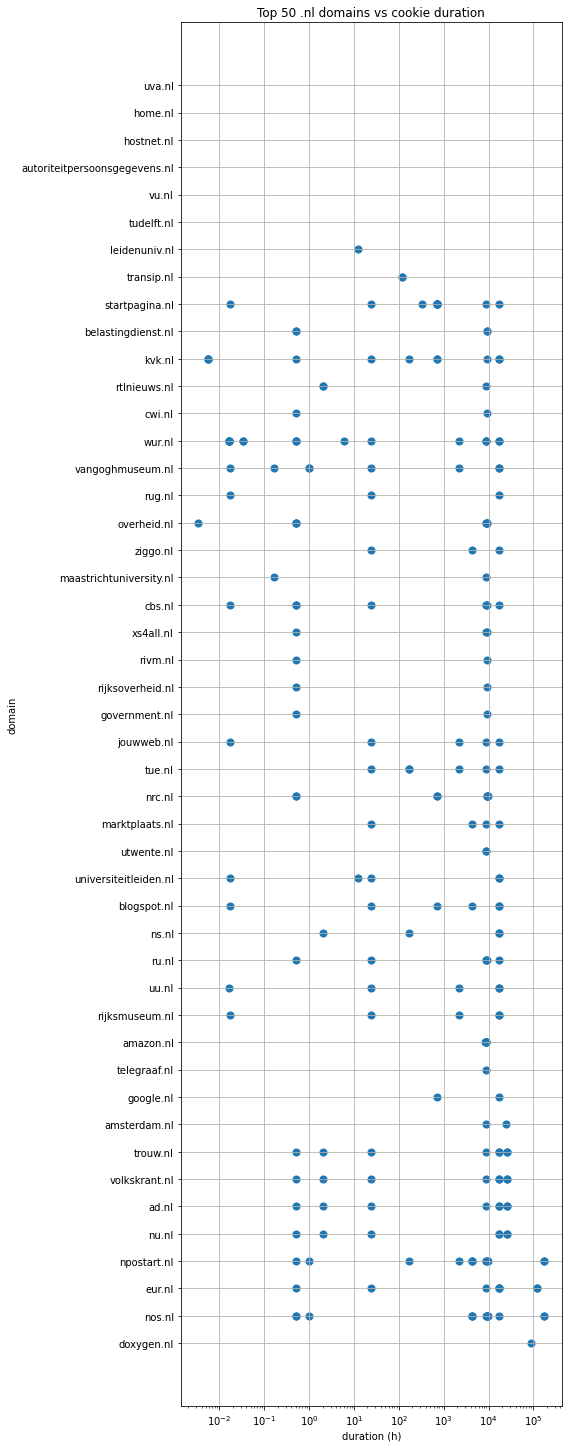

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8, 20))
exploded_df = cookie_df.explode('duration_s').sort_values('duration_mean', ascending=False)
exploded_df['duration (h)'] = exploded_df['duration_s'].apply(lambda x: x/3600)
exploded_df.plot(kind='scatter', x='duration (h)', y='domain', ax=ax, s=50)
# ax.set_yscale('log')
ax.set_xscale('log')
ax.grid()
# ax.tick_params(axis='x', rotation=70)
# ax.set_xticklabels(ax.get_xticklabels(), ha='right')
fig.tight_layout()
ax.set_title("Top 50 .nl domains vs cookie duration")

<AxesSubplot:xlabel='browser_module.banner_detected'>

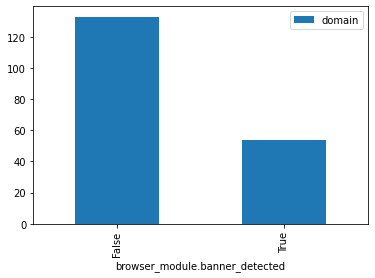

In [13]:
df.groupby('browser_module.banner_detected')[['domain']].count().plot( kind='bar')

## Discrepancies in cookies between protocols

In [14]:
def get_protocol(url: str):
    spl = url.split('.')[0]
    if 'www' in spl:
        return spl
    else:
        return spl.split("//")[0] + "//"

In [15]:
df['num_cookies'] = df['browser_module.cookies.cookies'].apply(len)

In [16]:
df['protocol'] = df['browser_module.uri'].apply(get_protocol)

In [22]:
# df[df['browser_module.banner_detected']].groupby('domain').count()
df[df['domain'] == 'blogspot.nl'][['browser_module.banner_detected', 'browser_module.uri']]

,browser_module.banner_detected,browser_module.uri
123,True,https://blogspot.nl
126,True,http://blogspot.nl
129,False,http://www.blogspot.nl
130,False,https://www.blogspot.nl


In [ ]:
df[df['num_cookies'] == df.groupby('domain')['num_cookies'].transform('max')].groupby('protocol')['protocol'].count()

In [31]:
for name, group in df.groupby('domain'):
    print(name, json.dumps(sorted(group['browser_module.cookies.cookies'].iloc[0], key=lambda x: x['name']), indent=4))

ad.nl [
    {
        "domain": ".dpgmedia.nl",
        "expiry": 1709832912,
        "httpOnly": false,
        "name": "_ga",
        "path": "/",
        "secure": false,
        "value": "GA1.2.343768656.1646760913",
        "duration_s": 63072000.85466218
    },
    {
        "domain": ".dpgmedia.nl",
        "expiry": 1646847312,
        "httpOnly": false,
        "name": "_gid",
        "path": "/",
        "secure": false,
        "value": "GA1.2.582474526.1646760913",
        "duration_s": 86400.85466217995
    },
    {
        "domain": ".dpgmedia.nl",
        "expiry": 1709832913,
        "httpOnly": false,
        "name": "_sp_id.e23f",
        "path": "/",
        "sameSite": "None",
        "secure": true,
        "value": "621b23a4-4891-4d4c-bd17-534da776658f.1646760913.1.1646760913.1646760913.7e60b2ec-a524-47b4-a2d6-f92ab0a4693b",
        "duration_s": 63072001.85466218
    },
    {
        "domain": ".dpgmedia.nl",
        "expiry": 1646762713,
        "httpOnly": fals